# CLT Stopping Criterion Comparisons

Author: Jimmy Nguyen (nguyen.hoang.jimmy42@gmail.com)

This notebook compares Kronecker, lattice, Halton, and IID MC sequences when using CubQMCCLT. We will use the Keister function and Asian Option as examples.

In [1]:
import qmcpy as qp
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

In [2]:
keister_tolerances = np.array([0.5, 0.3053, 0.1, 0.0695, 0.0158, 0.0097, 0.0059, 0.0022, 0.0013, 0.0008, 0.0005, 0.00025, 0.0001, 0.00005, 0.000025])
asian_tolerances = np.array([0.5, 0.3053, 0.1864, 0.1138, 0.1, 0.0695, 0.0424, 0.0259, 0.0158, 0.0097, 0.0059, 0.0036, 0.0022, 0.0013, 0.0008, 0.0005])
trials = 30
time_index = 0
n_index = 1

In [3]:
plt.rcParams["figure.dpi"] = 300
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['figure.constrained_layout.use'] = True
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fontsize = 15

In [4]:
alpha = np.loadtxt(Path('kron_vector/d13_n1e6_2e4alpha.txt'))
new_h = np.array([1, 444633, 468443, 63389, 310317, 297749, 330353, 144847, 428469, 339333, 19817, 76777, 71855], dtype = np.uint64)
kuo_h = np.array([1, 182667, 213731, 255351, 96013, 116671, 479315, 424089, 271103, 464421, 124483, 230887, 392877], dtype = np.uint64)

# Keister

In [5]:
keister_dimension = 3
keister_sequences = [qp.Kronecker(dimension = keister_dimension, alpha = alpha[:keister_dimension], randomize = True),
                     qp.Lattice(dimension = keister_dimension, generating_vector = new_h[:keister_dimension], d_max = keister_dimension, m_max = 2 ** 20),
                     qp.Lattice(dimension = keister_dimension, generating_vector = kuo_h[:keister_dimension], d_max = keister_dimension, m_max = 2 ** 20),
                     qp.Halton(dimension = keister_dimension)]
keister_results = np.empty((trials, 2, len(keister_sequences), len(keister_tolerances)))

Calculate the time to integrate and also the total number of sample points generated for each tolerance value when integrating the Keister function.

In [6]:
for trial in tqdm(range(trials)):
    for i, tolerance in enumerate(keister_tolerances):
        for j, sequence in enumerate(keister_sequences):
            data = qp.CubQMCCLT(qp.Keister(sequence), abs_tol = tolerance).integrate()[1]
            keister_results[trial][time_index][j][i] = data.time_integrate
            keister_results[trial][n_index][j][i] = data.n_total

100%|██████████| 30/30 [16:22<00:00, 32.74s/it]


IID points are MC, not QMC so we use `CubMCCLT` instead.

In [7]:
iid_len = len(keister_tolerances) - 4
iid = qp.IIDStdUniform(dimension=keister_dimension)
keister_iid_results = np.empty((trials, 2, len(keister_tolerances[:iid_len])))

for trial in tqdm(range(trials)):
    for i, tolerance in enumerate(keister_tolerances[:iid_len]):
        data = qp.CubMCCLT(qp.Keister(iid), abs_tol = tolerance).integrate()[1]
        keister_iid_results[trial][time_index][i] = data.time_integrate
        keister_iid_results[trial][n_index][i] = data.n_total

100%|██████████| 30/30 [31:16<00:00, 62.54s/it]


In [8]:
median_times = np.empty((len(keister_sequences), len(keister_tolerances)))
first_quartile_times = np.empty((len(keister_sequences), len(keister_tolerances)))
third_quartile_times = np.empty((len(keister_sequences), len(keister_tolerances)))
for i in range(len(keister_sequences)):
    for j in range(len(keister_tolerances)):
        times = keister_results[:, time_index, i, j]
        median_times[i][j] = np.median(times)
        first_quartile_times[i][j] = np.quantile(times, 0.25)
        third_quartile_times[i][j] = np.quantile(times, 0.75)

iid_median_times = np.empty(iid_len)
iid_first_quartile_times = np.empty(iid_len)
iid_third_quartile_times = np.empty(iid_len)
for i in range(iid_len):
    times = keister_iid_results[:, time_index, i]
    iid_median_times[i] = np.median(times)
    iid_first_quartile_times[i] = np.quantile(times, 0.25)
    iid_third_quartile_times[i] = np.quantile(times, 0.75)

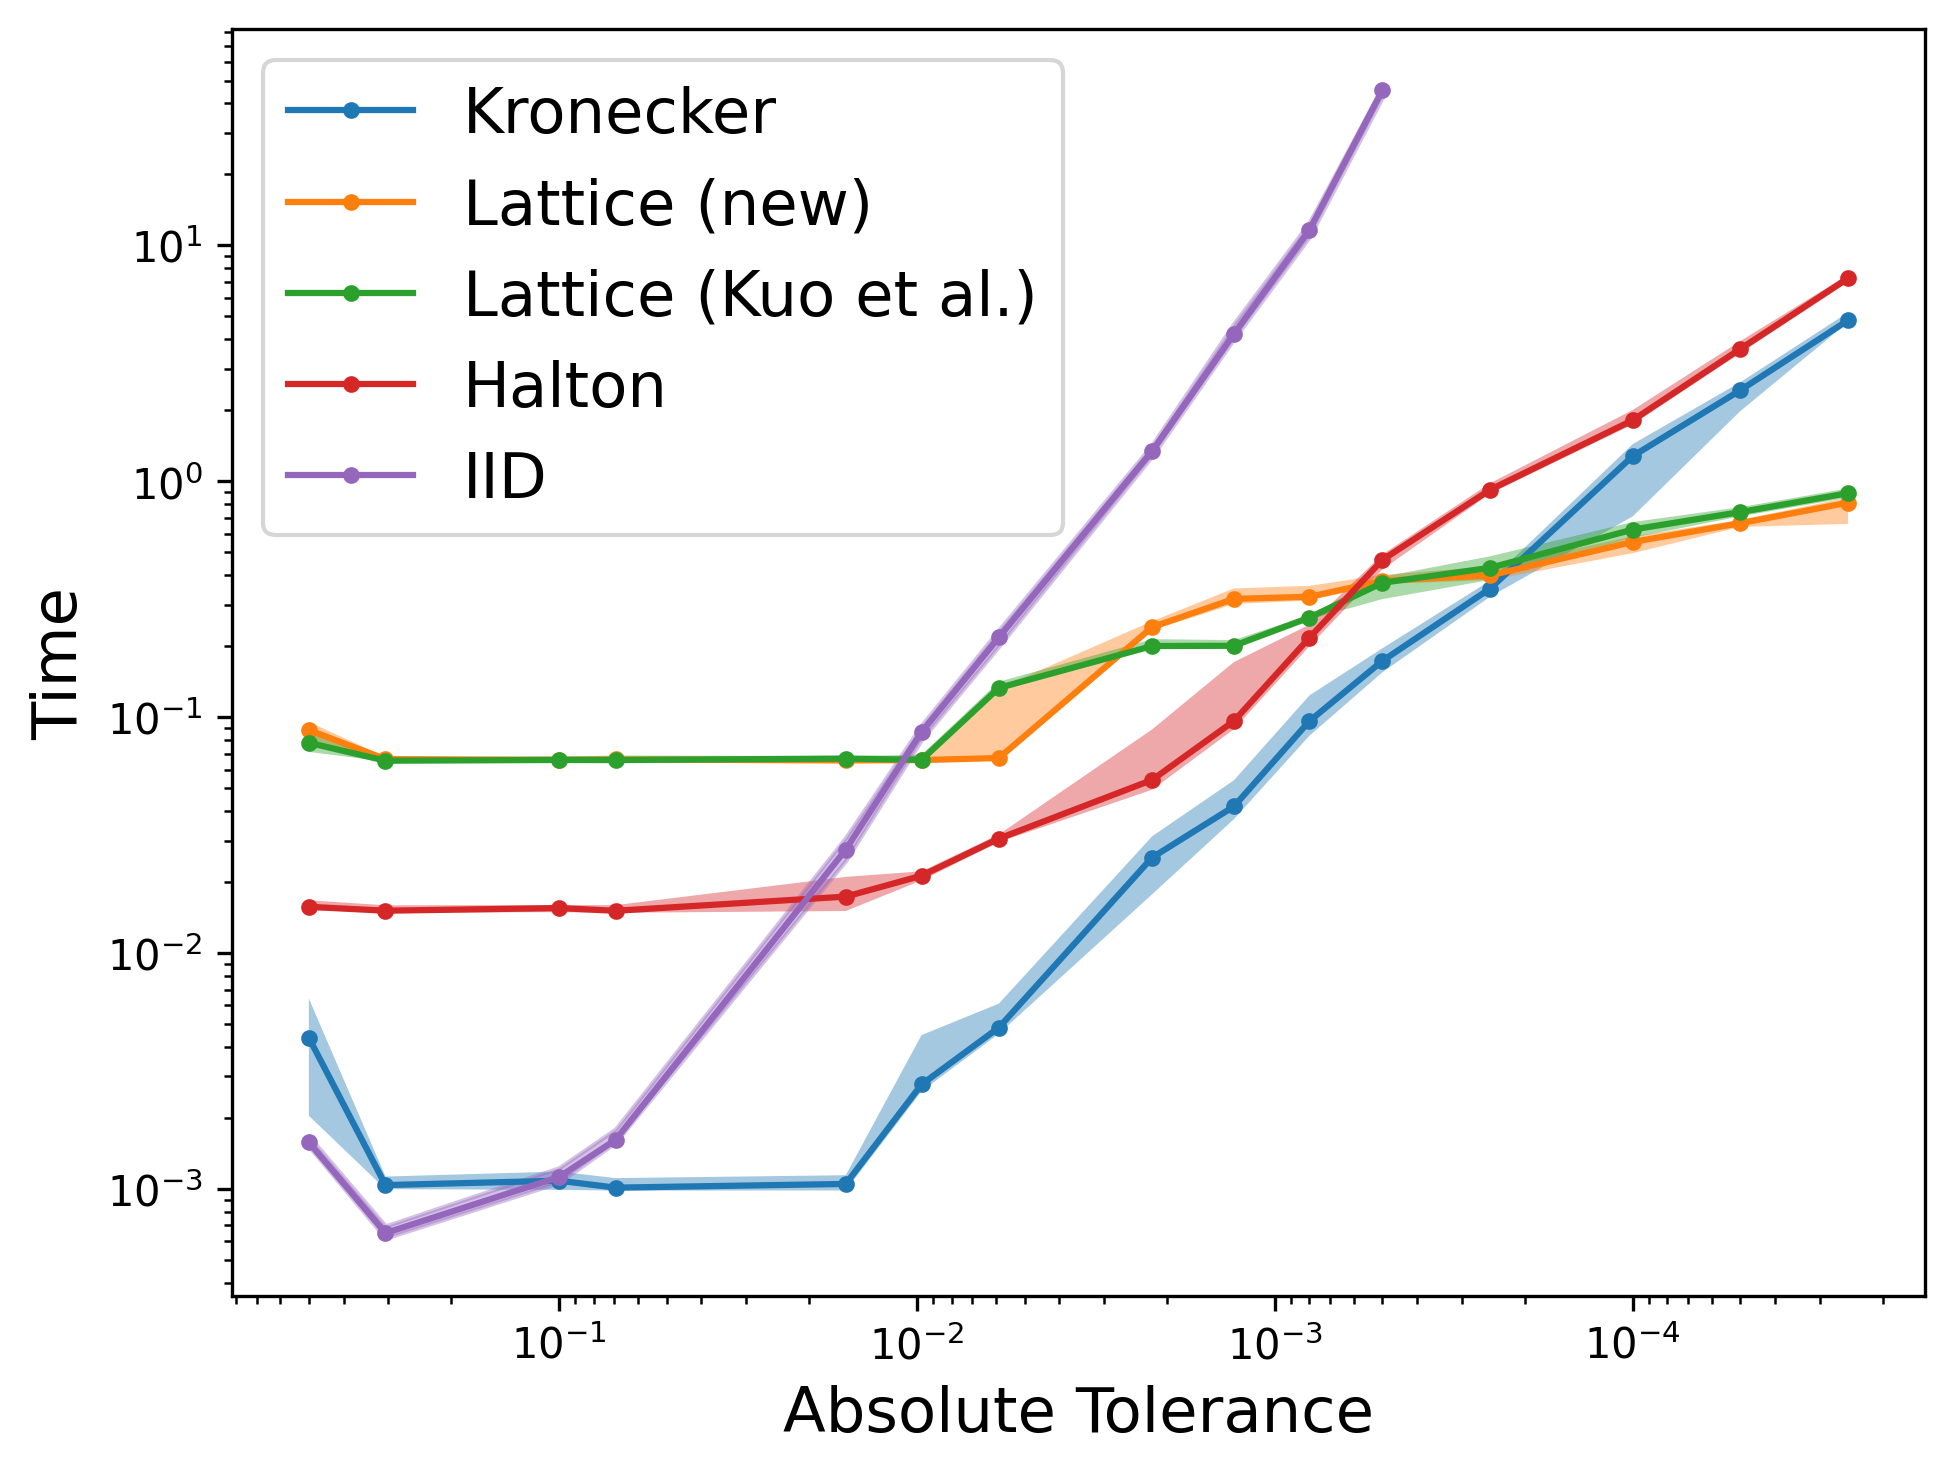

In [9]:
sequences = ['Kronecker', 'Lattice (new)', 'Lattice (Kuo et al.)', 'Halton']
fig, ax = plt.subplots(layout = "constrained")

ax.set_xscale('log')
ax.set_yscale('log')
ax.invert_xaxis()
for i, seq in enumerate(sequences):
    ax.plot(keister_tolerances, median_times[i], label = seq, color = colors[i], linestyle='-', marker = '.')
    ax.fill_between(keister_tolerances, first_quartile_times[i], third_quartile_times[i], linestyle='-', alpha = 0.4)

ax.plot(keister_tolerances[:iid_len], iid_median_times, label = 'IID', linestyle='-', marker = '.', color = colors[i + 1])
ax.fill_between(keister_tolerances[:iid_len], iid_first_quartile_times, iid_third_quartile_times, color = colors[i + 1], linestyle='-', alpha = 0.4)

ax.set_xlabel('Absolute Tolerance', fontsize = fontsize)
ax.set_ylabel('Time', fontsize = fontsize)
ax.legend(loc='upper left', fontsize = fontsize)

In [10]:
median_n = np.empty((len(keister_sequences), len(keister_tolerances)))
first_quartile_n = np.empty((len(keister_sequences), len(keister_tolerances)))
third_quartile_n = np.empty((len(keister_sequences), len(keister_tolerances)))
for i in range(len(keister_sequences)):
    for j in range(len(keister_tolerances)):
        n = keister_results[:, n_index, i, j]
        median_n[i][j] = np.median(n)
        first_quartile_n[i][j] = np.quantile(n, 0.25)
        third_quartile_n[i][j] = np.quantile(n, 0.75)

iid_median_n = np.empty(iid_len)
iid_first_quartile_n = np.empty(iid_len)
iid_third_quartile_n = np.empty(iid_len)
for i in range(iid_len):
    n = keister_iid_results[:, n_index, i]
    iid_median_n[i] = np.median(n)
    iid_first_quartile_n[i] = np.quantile(n, 0.25)
    iid_third_quartile_n[i] = np.quantile(n, 0.75)

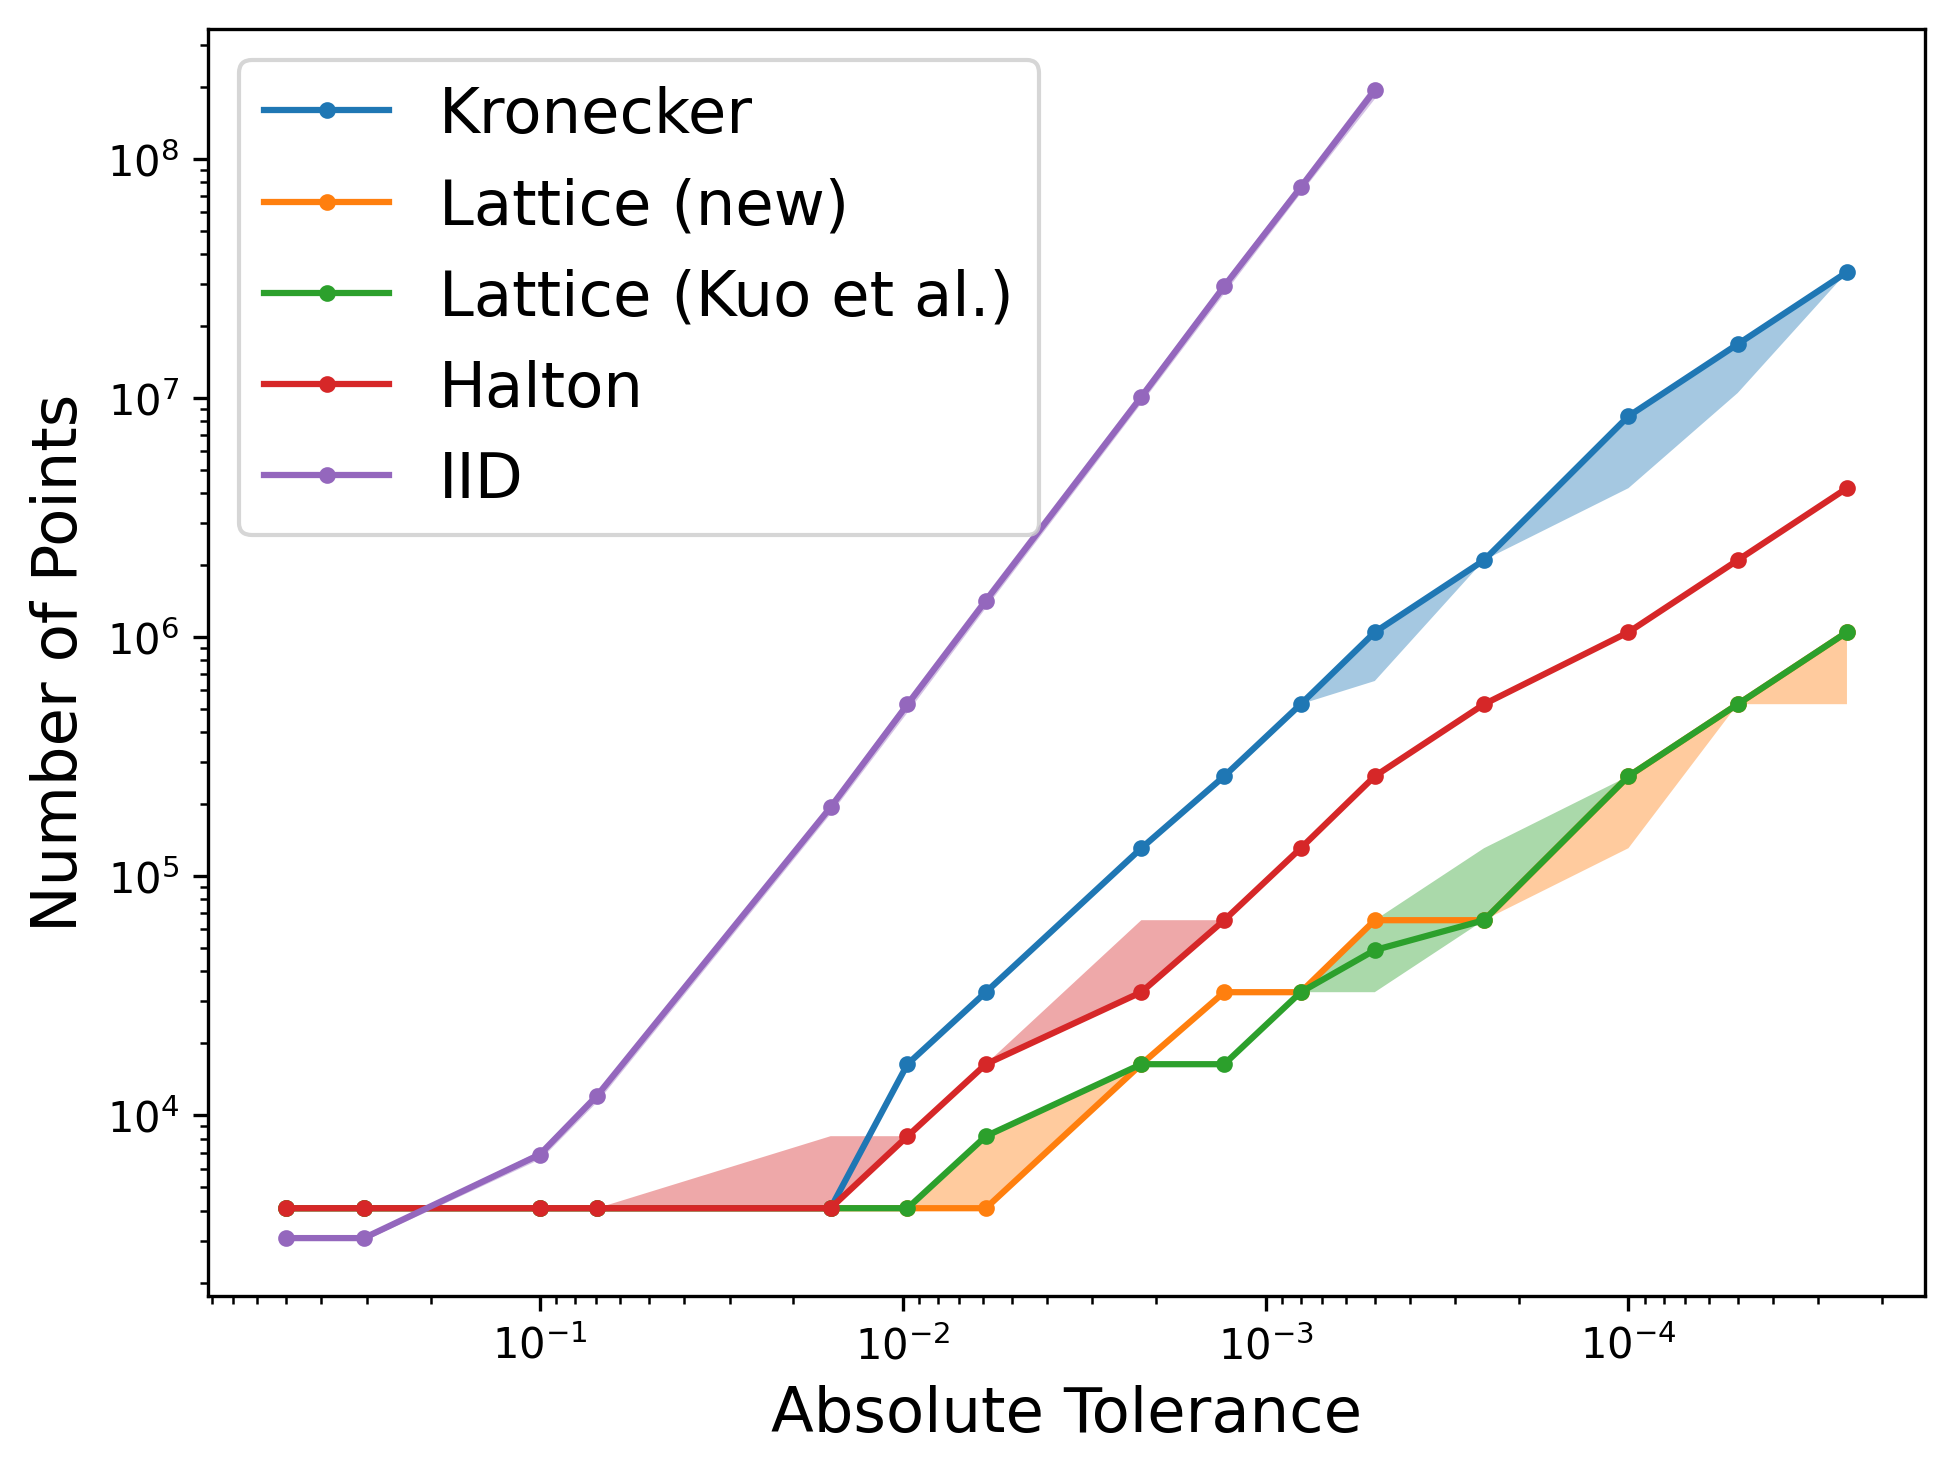

In [11]:
fig, ax = plt.subplots(layout = "constrained")

ax.set_xscale('log')
ax.set_yscale('log')
ax.invert_xaxis()
for i, seq in enumerate(sequences):
    ax.plot(keister_tolerances, median_n[i], label = seq, color = colors[i], linestyle='-', marker= '.')
    ax.fill_between(keister_tolerances, first_quartile_n[i], third_quartile_n[i], linestyle='-', alpha = 0.4)


ax.fill_between(keister_tolerances[:iid_len], iid_first_quartile_n, iid_third_quartile_n, color = colors[i + 1], linestyle='-', alpha = 0.4)
ax.plot(keister_tolerances[:iid_len], iid_median_n, label = 'IID', linestyle='-', marker= '.', color = colors[i + 1])

ax.set_xlabel('Absolute Tolerance', fontsize = fontsize)
ax.set_ylabel('Number of Points', fontsize = fontsize)
ax.legend(loc='upper left', fontsize = fontsize)

# Asian Option

In [12]:
asian_dimension = 13
asian_sequences = [qp.Kronecker(dimension = asian_dimension, alpha = alpha[:asian_dimension], randomize=True),
                   qp.Lattice(dimension = asian_dimension, generating_vector = new_h[:asian_dimension], d_max = asian_dimension, m_max = 2 ** 20),
                   qp.Lattice(dimension = asian_dimension, generating_vector = kuo_h[:asian_dimension], d_max = asian_dimension, m_max = 2 ** 20),
                   qp.Halton(dimension = asian_dimension)]


asian_results = np.empty((trials, 2, len(asian_sequences), len(asian_tolerances)))

In [13]:
for trial in tqdm(range(trials)):
    for i, tolerance in enumerate(asian_tolerances):
        for j, sequence in enumerate(asian_sequences):
            solution, data = qp.CubQMCCLT(qp.AsianOption(sampler = sequence,
                                                        volatility = 0.50,
                                                        start_price = 120,
                                                        strike_price = 130,
                                                        interest_rate = 0.02,
                                                        t_final = 1,
                                                        call_put = 'call',
                                                        mean_type = 'arithmetic'), abs_tol = tolerance).integrate()
            
            asian_results[trial][time_index][j][i] = data.time_integrate
            asian_results[trial][n_index][j][i] = data.n_total
            del solution
            del data

100%|██████████| 30/30 [1:24:37<00:00, 169.26s/it]


In [15]:
iid = qp.IIDStdUniform(dimension = asian_dimension)
iid_len = 6
asian_iid_results = np.empty((trials, 2, len(asian_tolerances[:iid_len])))
for trial in tqdm(range(trials)):
    for i, tolerance in enumerate(asian_tolerances[:iid_len]):
        solution, data = qp.CubMCCLT(qp.AsianOption(sampler = iid,
                                                    volatility = 0.50,
                                                    start_price = 120,
                                                    strike_price = 130,
                                                    interest_rate = 0.02,
                                                    t_final = 1,
                                                    call_put = 'call',
                                                    mean_type = 'arithmetic'), abs_tol=tolerance).integrate()
        
        asian_iid_results[trial][time_index][i] = data.time_integrate
        asian_iid_results[trial][n_index][i] = data.n_total

100%|██████████| 30/30 [00:56<00:00,  1.88s/it]


In [16]:
median_times = np.empty((len(asian_sequences), len(asian_tolerances)))
first_quartile_times = np.empty((len(asian_sequences), len(asian_tolerances)))
third_quartile_times = np.empty((len(asian_sequences), len(asian_tolerances)))

for i in range(len(asian_sequences)):
    for j in range(len(asian_tolerances)):
        times = asian_results[:, time_index, i, j]
        median_times[i][j] = np.median(times)
        first_quartile_times[i][j] = np.quantile(times, 0.25)
        third_quartile_times[i][j] = np.quantile(times, 0.75)

iid_median_times = np.empty(iid_len)
iid_first_quartile_times = np.empty(iid_len)
iid_third_quartile_times = np.empty(iid_len)
for i in range(iid_len):
    times = asian_iid_results[:, time_index, i]
    iid_median_times[i] = np.median(times)
    iid_first_quartile_times[i] = np.quantile(times, 0.25)
    iid_third_quartile_times[i] = np.quantile(times, 0.75)

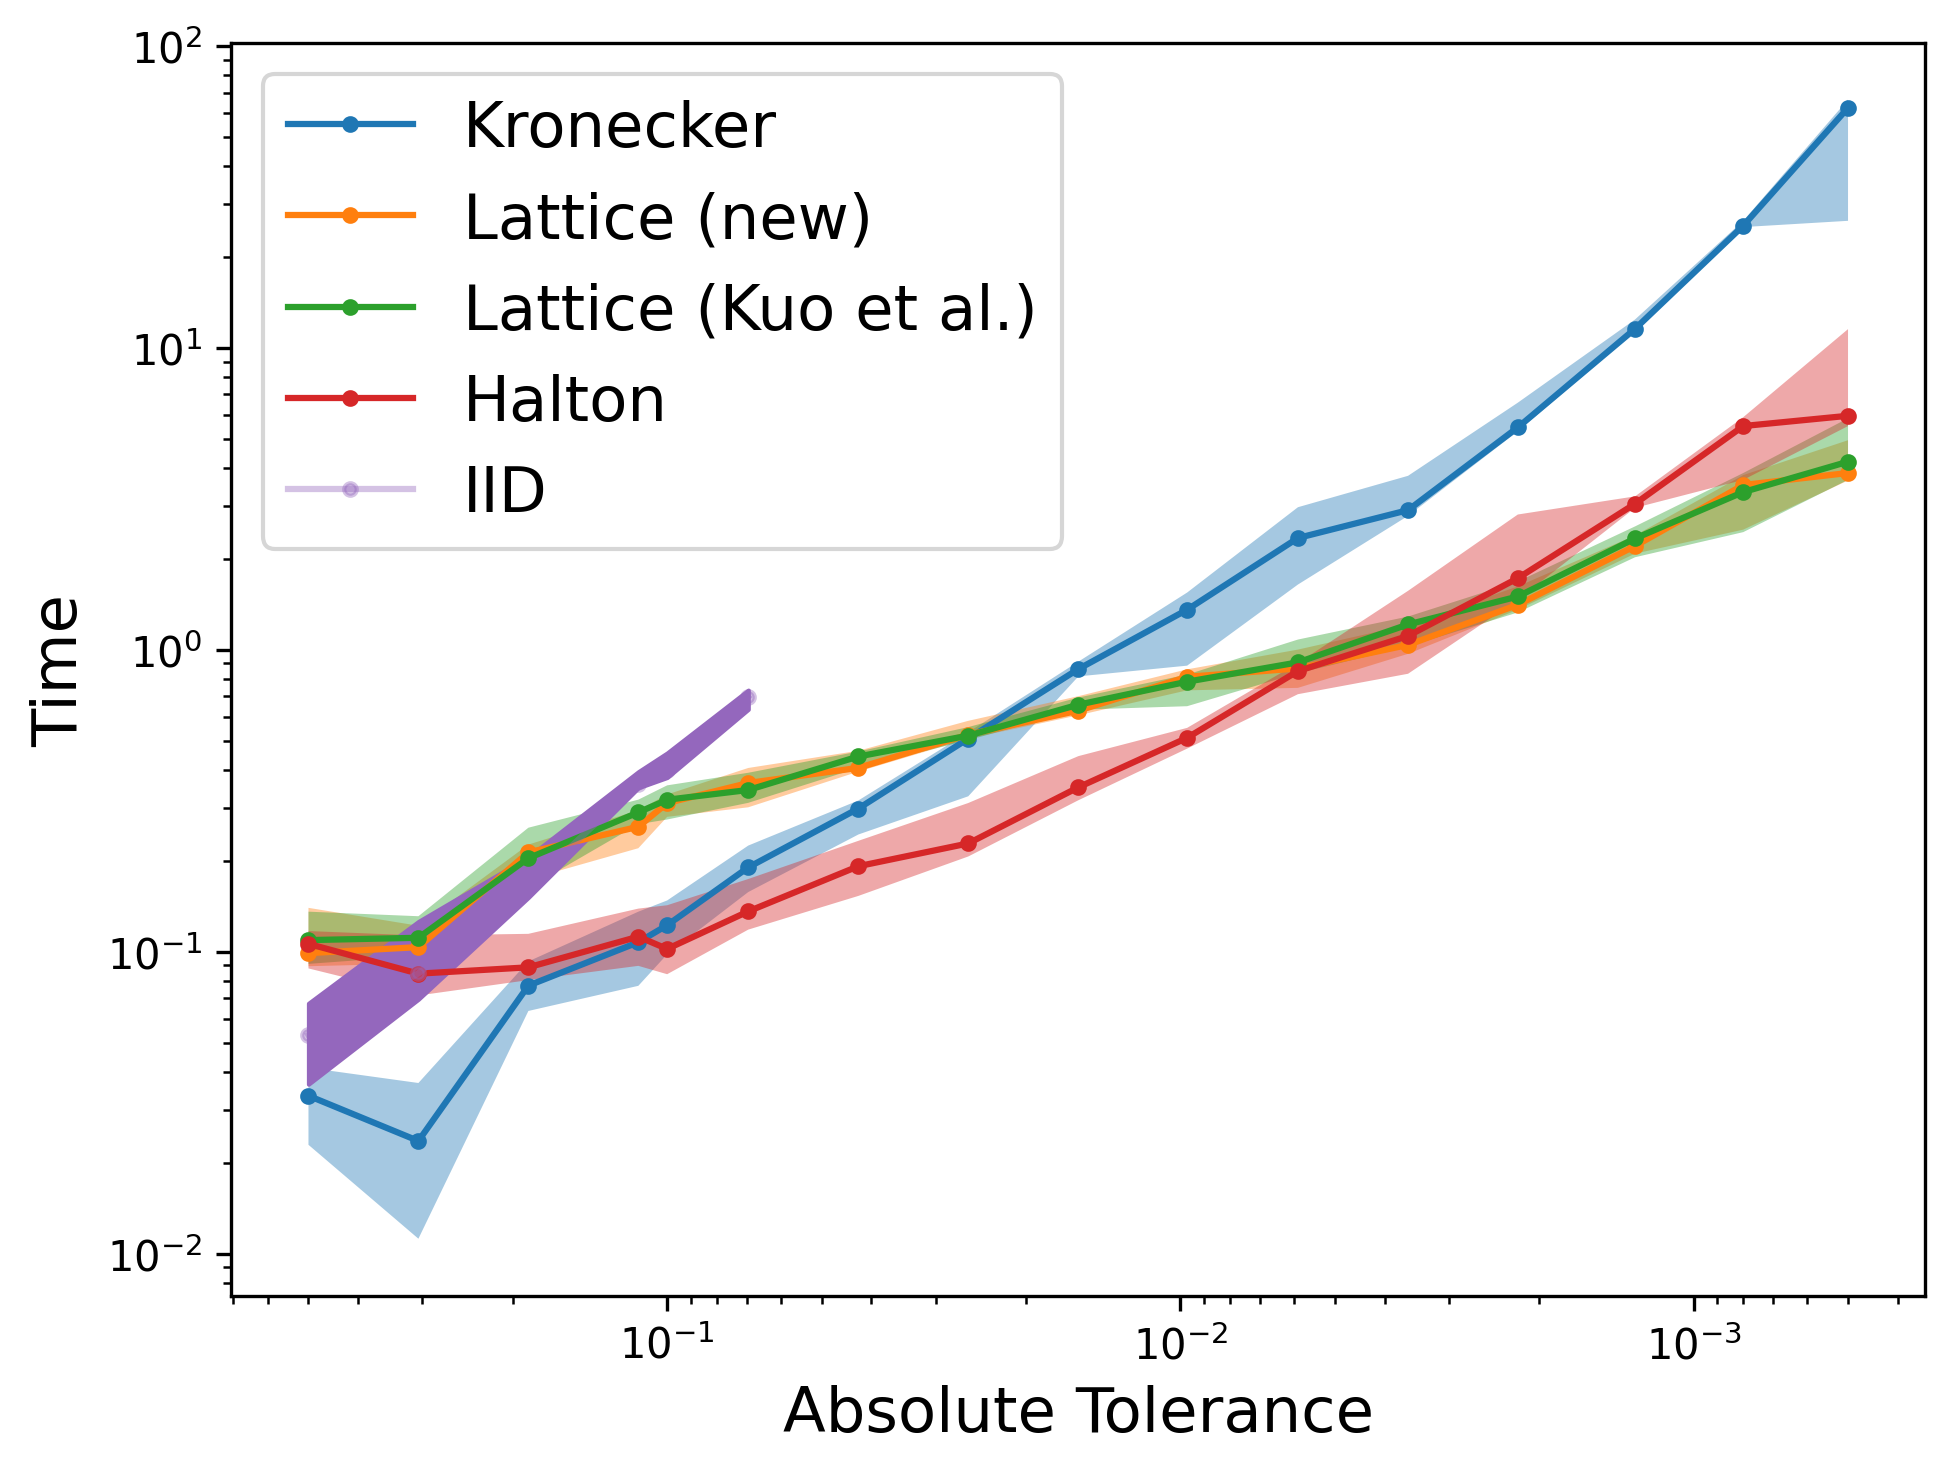

In [18]:
fig, ax = plt.subplots(layout = "constrained")

ax.set_xscale('log')
ax.set_yscale('log')
ax.invert_xaxis()
for i, seq in enumerate(sequences):
    ax.plot(asian_tolerances, median_times[i], label = seq, color = colors[i], linestyle='-', marker = '.')
    ax.fill_between(asian_tolerances, first_quartile_times[i], third_quartile_times[i], linestyle='-', alpha = 0.4)

ax.plot(asian_tolerances[:iid_len], iid_median_times, label = 'IID', linestyle='-', marker = '.', color = colors[i + 1], alpha = 0.4)
ax.fill_between(asian_tolerances[:iid_len], iid_first_quartile_times, iid_third_quartile_times, color = colors[i + 1], linestyle='-')

ax.set_xlabel('Absolute Tolerance', fontsize = fontsize)
ax.set_ylabel('Time', fontsize = fontsize)
ax.legend(loc='upper left', fontsize = fontsize)

In [19]:
median_n = np.empty((len(asian_sequences), len(asian_tolerances)))
first_quartile_n = np.empty((len(asian_sequences), len(asian_tolerances)))
third_quartile_n = np.empty((len(asian_sequences), len(asian_tolerances)))

for i in range(len(asian_sequences)):
    for j in range(len(asian_tolerances)):
        n = asian_results[:, n_index, i, j]
        median_n[i][j] = np.median(n)
        first_quartile_n[i][j] = np.quantile(n, 0.25)
        third_quartile_n[i][j] = np.quantile(n, 0.75)

iid_median_n = np.empty(iid_len)
iid_first_quartile_n = np.empty(iid_len)
iid_third_quartile_n = np.empty(iid_len)
for i in range(iid_len):
    n = asian_iid_results[:, n_index, i]
    iid_median_n[i] = np.median(n)
    iid_first_quartile_n[i] = np.quantile(n, 0.25)
    iid_third_quartile_n[i] = np.quantile(n, 0.75)

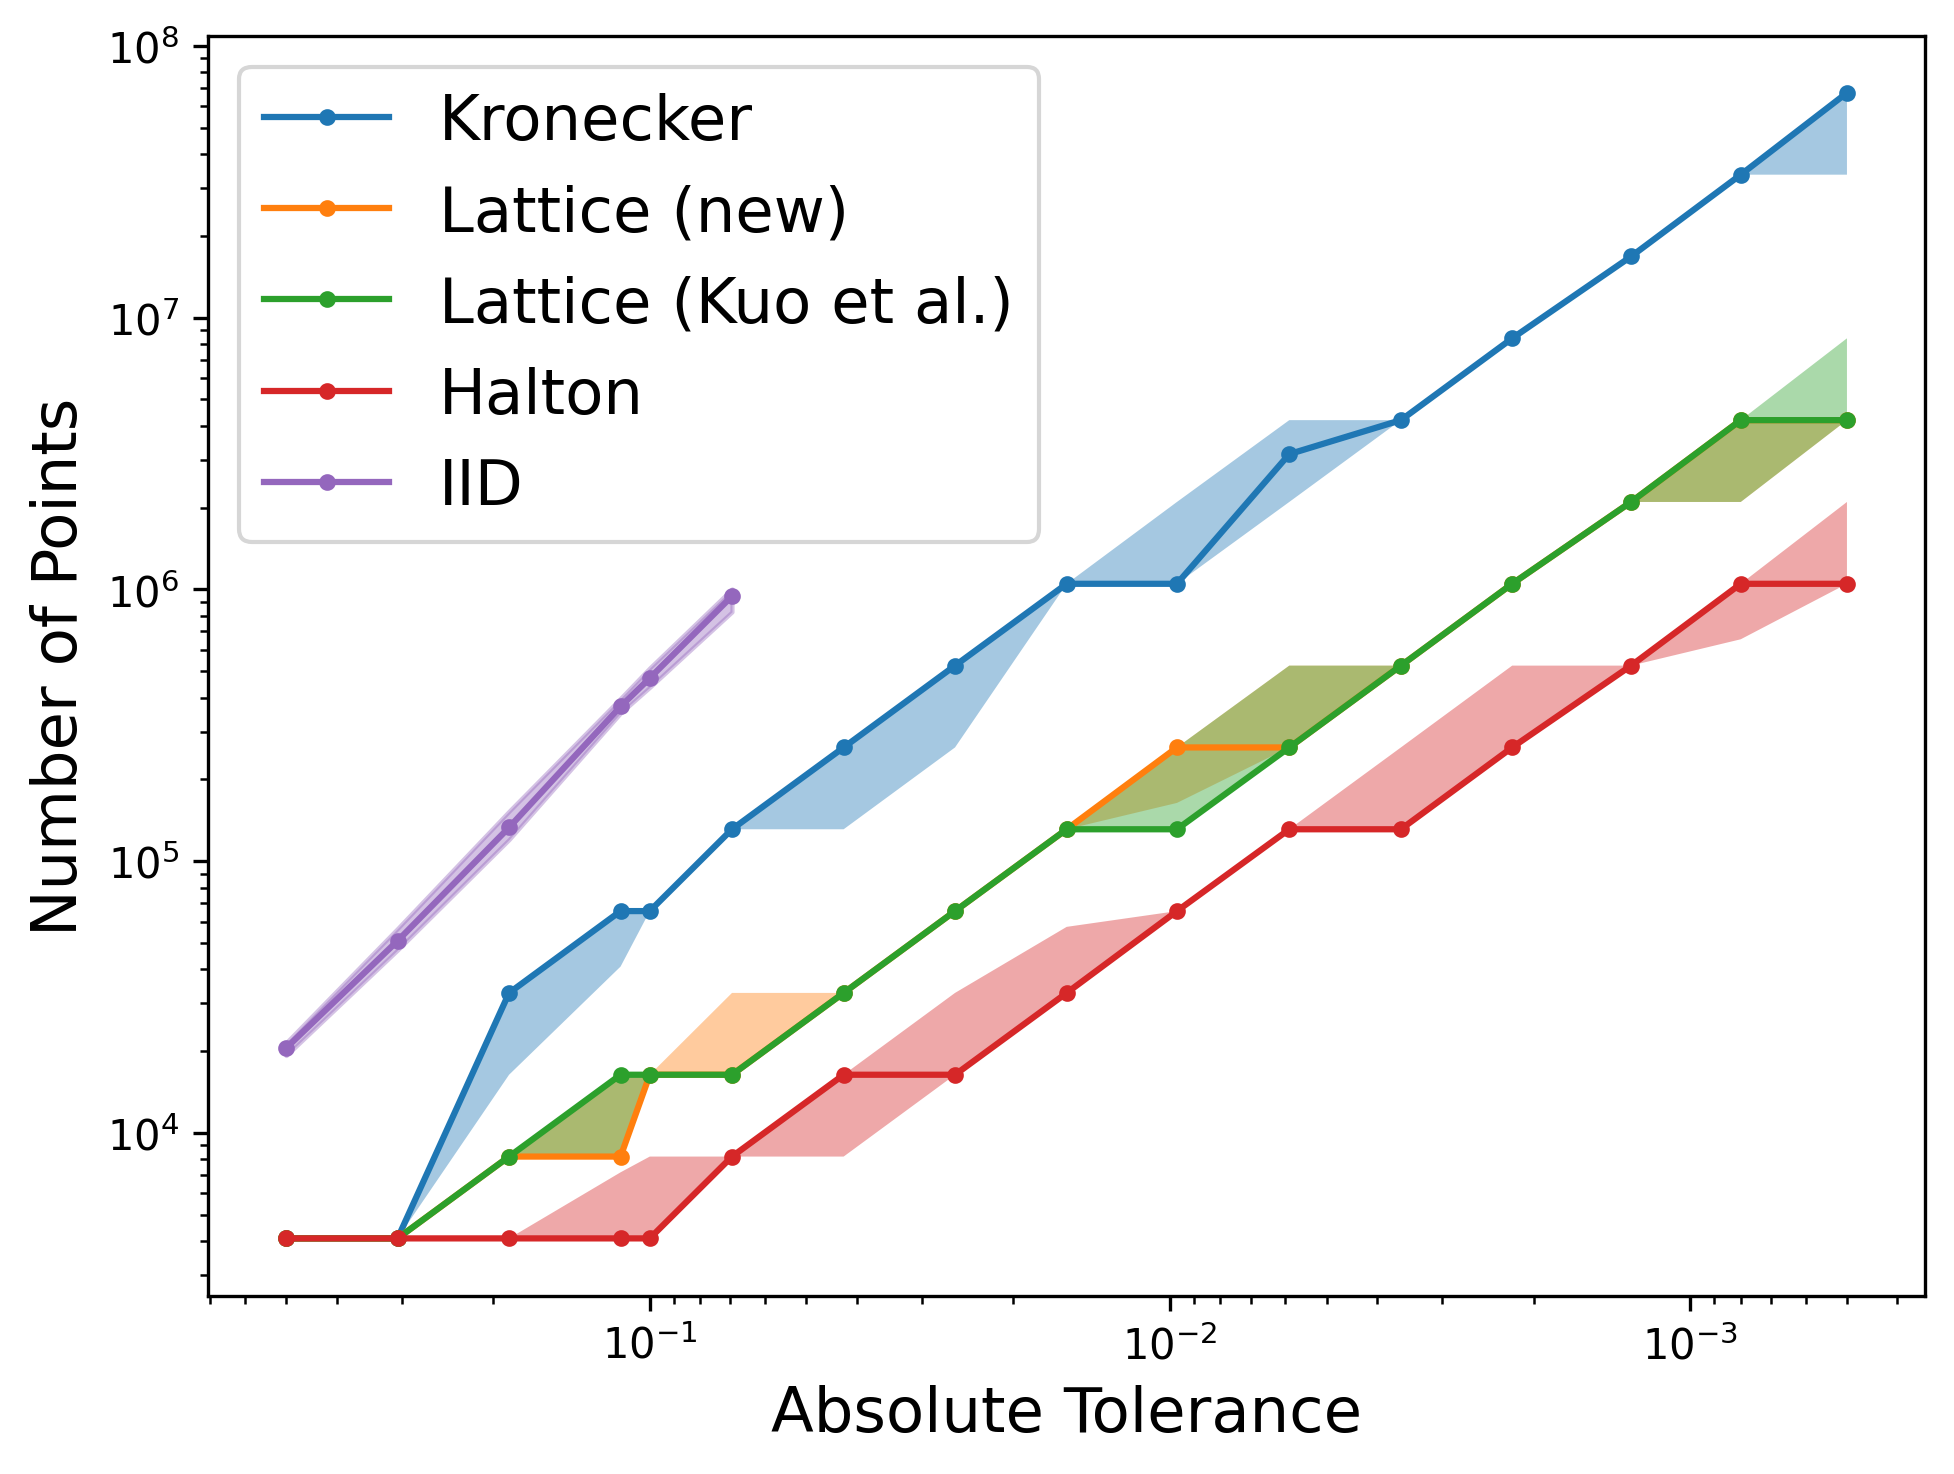

In [20]:
fig, ax = plt.subplots(layout = "constrained")

ax.set_xscale('log')
ax.set_yscale('log')
ax.invert_xaxis()
for i, seq in enumerate(sequences):
    ax.plot(asian_tolerances, median_n[i], label = seq, color = colors[i], linestyle='-', marker= '.')
    ax.fill_between(asian_tolerances, first_quartile_n[i], third_quartile_n[i], linestyle='-', alpha = 0.4)


ax.fill_between(asian_tolerances[:iid_len], iid_first_quartile_n, iid_third_quartile_n, color = colors[i + 1], linestyle='-', alpha = 0.4)
ax.plot(asian_tolerances[:iid_len], iid_median_n, label = 'IID', linestyle='-', marker= '.', color = colors[i + 1])

ax.set_xlabel('Absolute Tolerance', fontsize = fontsize)
ax.set_ylabel('Number of Points', fontsize = fontsize)
ax.legend(loc='upper left', fontsize = fontsize)